In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python

import io # Input/Output Module
import os # OS interfaces
import cv2 # OpenCV package
import numpy as np # linear algebra
import keras
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from urllib import request # module for opening HTTP requests
from matplotlib import pyplot as plt # Plotting library

#Extra libraries for hog and pca
from skimage.io import imread
from skimage.transform import resize
from skimage.feature import hog
from skimage import exposure
from skimage import data
from skimage.color import (rgb2gray)

import time
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns
from IPython.display import clear_output

<div style="width:100%; height:140px">
    <img src="https://www.kuleuven.be/internationaal/thinktank/fotos-en-logos/ku-leuven-logo.png/image_preview" width = 300px, heigh = auto align=left>
</div>


KUL H02A5a Computer Vision: Group Assignment 1
---------------------------------------------------------------
Student numbers: <span style="color:red">r0703889, r0909802, r0716758, r0916443, r0822692</span>.

The goal of this assignment is to explore more advanced techniques for constructing features that better describe objects of interest and to perform face recognition using these features. This assignment will be delivered in groups of 5 (either composed by you or randomly assigned by your TA's).

In this assignment you are a group of computer vision experts that have been invited to ECCV 2021 to do a tutorial about  "Feature representations, then and now". To prepare the tutorial you are asked to participate in a kaggle competition and to release a notebook that can be easily studied by the tutorial participants. Your target audience is: (master) students who want to get a first hands-on introduction to the techniques that you apply.

---------------------------------------------------------------
This notebook is structured as follows:
0. Data loading & Preprocessing
1. Feature Representations
2. Evaluation Metrics 
3. Classifiers
4. Experiments
5. Publishing best results
6. Discussion

Make sure that your notebook is **self-contained** and **fully documented**. Walk us through all steps of your code. Treat your notebook as a tutorial for students who need to get a first hands-on introduction to the techniques that you apply. Provide strong arguments for the design choices that you made and what insights you got from your experiments. Make use of the *Group assignment* forum/discussion board on Toledo if you have any questions.

Fill in your student numbers above and get to it! Good luck! 


<div class="alert alert-block alert-info">
<b>NOTE:</b> This notebook is just a example/template, feel free to adjust in any way you please! Just keep things organised and document accordingly!
</div>

<div class="alert alert-block alert-info">
<b>NOTE:</b> Clearly indicate the improvements that you make!!! You can for instance use titles like: <i>3.1. Improvement: Non-linear SVM with RBF Kernel.<i>
</div>
    
---------------------------------------------------------------
# 0. Data loading & Preprocessing

## 0.1. Loading data
The training set is many times smaller than the test set and this might strike you as odd, however, this is close to a real world scenario where your system might be put through daily use! In this session we will try to do the best we can with the data that we've got! 

In [2]:
os.listdir('/kaggle/input/computer-vision-assignment/kul-h02a5a-computer-vision-ga1-2022')
#os.listdir('../cv_assignment1')

['test_set.csv', 'train_set.csv', 'test', 'train']

In [3]:
# Input data files are available in the read-only "../input/" directory

#train = pd.read_csv(
#    '/kaggle/input/computer-vision-assignment/kul-h02a5a-computer-vision-ga1-2022/train_set.csv', index_col = 0)
#train.index = train.index.rename('id')

#test = pd.read_csv(
#    '/kaggle/input/computer-vision-assignment/kul-h02a5a-computer-vision-ga1-2022/test_set.csv', index_col = 0)
#test.index = test.index.rename('id')

# read the images as numpy arrays and store in "img" column
#train['img'] = [cv2.cvtColor(np.load('/kaggle/input/computer-vision-assignment/kul-h02a5a-computer-vision-ga1-2022/train/train_{}.npy'.format(index), allow_pickle=False), cv2.COLOR_BGR2RGB) 
#                for index, row in train.iterrows()]

#test['img'] = [cv2.cvtColor(np.load('/kaggle/input/computer-vision-assignment/kul-h02a5a-computer-vision-ga1-2022/test/test_{}.npy'.format(index), allow_pickle=False), cv2.COLOR_BGR2RGB) 
#                for index, row in test.iterrows()]
  

#train_size, test_size = len(train),len(test)

#"The training set contains {} examples, the test set contains {} examples.".format(train_size, test_size)

In [4]:
# Input data files are available in the read-only "../input/" directory
# path local
# path = ''
# path kaggle
path = '/kaggle/input/computer-vision-assignment/kul-h02a5a-computer-vision-ga1-2022/'


train = pd.read_csv(
    '{}train_set.csv'.format(path), index_col = 0)
train.index = train.index.rename('id')

test = pd.read_csv(
    '{}test_set.csv'.format(path), index_col = 0)
test.index = test.index.rename('id')

# read the images as numpy arrays and store in "img" column
train['img'] = [cv2.cvtColor(np.load('{}train/train_{}.npy'.format(path, index), allow_pickle=False), cv2.COLOR_BGR2RGB) 
                for index, row in train.iterrows()]

test['img'] = [cv2.cvtColor(np.load('{}test/test_{}.npy'.format(path, index), allow_pickle=False), cv2.COLOR_BGR2RGB) 
                for index, row in test.iterrows()]
  

train_size, test_size = len(train),len(test)

"The training set contains {} examples, the test set contains {} examples.".format(train_size, test_size)

'The training set contains 80 examples, the test set contains 1816 examples.'

*Note: this dataset is a subset of the* [*VGG face dataset*](https://www.robots.ox.ac.uk/~vgg/data/vgg_face/).

## 0.2. A first look
Let's have a look at the data columns and class distribution.

In [5]:
# The training set contains an identifier, name, image information and class label
train.head()

name  class                                                img
id                                                                        
0     Mila_Kunis      2  [[[50, 31, 25], [49, 30, 24], [49, 30, 24], [4...
1     Mila_Kunis      2  [[[24, 35, 31], [25, 36, 32], [27, 36, 33], [2...
2   Michael_Cera      0  [[[111, 112, 106], [111, 112, 106], [112, 113,...
3     Mila_Kunis      2  [[[223, 223, 223], [223, 223, 223], [223, 223,...
4   Michael_Cera      0  [[[195, 195, 205], [195, 195, 205], [190, 192,...

In [6]:
# The test set only contains an identifier and corresponding image information.

test.head(1)

img
id                                                   
0   [[[209, 210, 205], [208, 209, 204], [208, 209,...

In [7]:
# The class distribution in the training set:
train.groupby('name').agg({'img':'count', 'class': 'max'})

img  class
name                       
Jesse_Eisenberg   30      1
Michael_Cera      10      0
Mila_Kunis        30      2
Sarah_Hyland      10      0

Note that **Jesse is assigned the classification label 1**, and **Mila is assigned the classification label 2**. The dataset also contains 20 images of **look alikes (assigned classification label 0)** and the raw images. 

## 0.3. Preprocess data
### 0.3.1 Example: HAAR face detector
In this example we use the [HAAR feature based cascade classifiers](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_objdetect/py_face_detection/py_face_detection.html) to detect faces, then the faces are resized so that they all have the same shape. If there are multiple faces in an image, we only take the first one. 

<div class="alert alert-block alert-info"> <b>NOTE:</b> You can write temporary files to <code>/kaggle/temp/</code> or <code>../../tmp</code>, but they won't be saved outside of the current session
</div>


In [8]:
class HAARPreprocessor():
    """Preprocessing pipeline built around HAAR feature based cascade classifiers. """
    
    def __init__(self, path, face_size):
        self.face_size = face_size
        file_path = os.path.join(path, "haarcascade_frontalface_default.xml")
        if not os.path.exists(file_path): 
            if not os.path.exists(path):
                os.mkdir(path)
            self.download_model(file_path)
        
        self.classifier = cv2.CascadeClassifier(file_path)
  
    def download_model(self, path):
        url = "https://raw.githubusercontent.com/opencv/opencv/master/data/"\
            "haarcascades/haarcascade_frontalface_default.xml"
        
        with request.urlopen(url) as r, open(path, 'wb') as f:
            f.write(r.read())
            
    def detect_faces(self, img):
        """Detect all faces in an image."""
        
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        return self.classifier.detectMultiScale(
            img_gray,
            scaleFactor=1.2,
            minNeighbors=7, #5
            minSize=(15, 15), #(30,30)
            flags=cv2.CASCADE_SCALE_IMAGE
        )
        
    def extract_faces(self, img):
        """Returns all faces (cropped) in an image."""
        
        faces = self.detect_faces(img)

        return [img[y:y+h, x:x+w] for (x, y, w, h) in faces]
    
    def preprocess(self, data_row):
        faces = self.extract_faces(data_row['img'])
        
        # if no faces were found, return None
        if len(faces) == 0:
            nan_img = np.empty(self.face_size + (3,))
            nan_img[:] = np.nan
            return nan_img
        
        # only return the first face
        return cv2.resize(faces[0], self.face_size, interpolation = cv2.INTER_AREA)
            
    def __call__(self, data):
        return np.stack([self.preprocess(row) for _, row in data.iterrows()]).astype(int)

**Visualise**

Let's plot a few examples.

In [9]:
# parameter to play with 
# Set to 80x80 for the HOG feature extractor
FACE_SIZE = (100, 100)

def plot_image_sequence(data, n, imgs_per_row=7):
    n_rows = 1 + int(n/(imgs_per_row+1))
    n_cols = min(imgs_per_row, n)

    f,ax = plt.subplots(n_rows,n_cols, figsize=(10*n_cols,10*n_rows))
    for i in range(n):
        if n == 1:
            ax.imshow(data[i])
        elif n_rows > 1:
            ax[int(i/imgs_per_row),int(i%imgs_per_row)].imshow(data[i])
        else:
            ax[int(i%n)].imshow(data[i])
    plt.show()

    
#preprocessed data 
preprocessor = HAARPreprocessor(path = '../../tmp', face_size=FACE_SIZE)

train_X, train_y = preprocessor(train), train['class'].values
test_X = preprocessor(test)



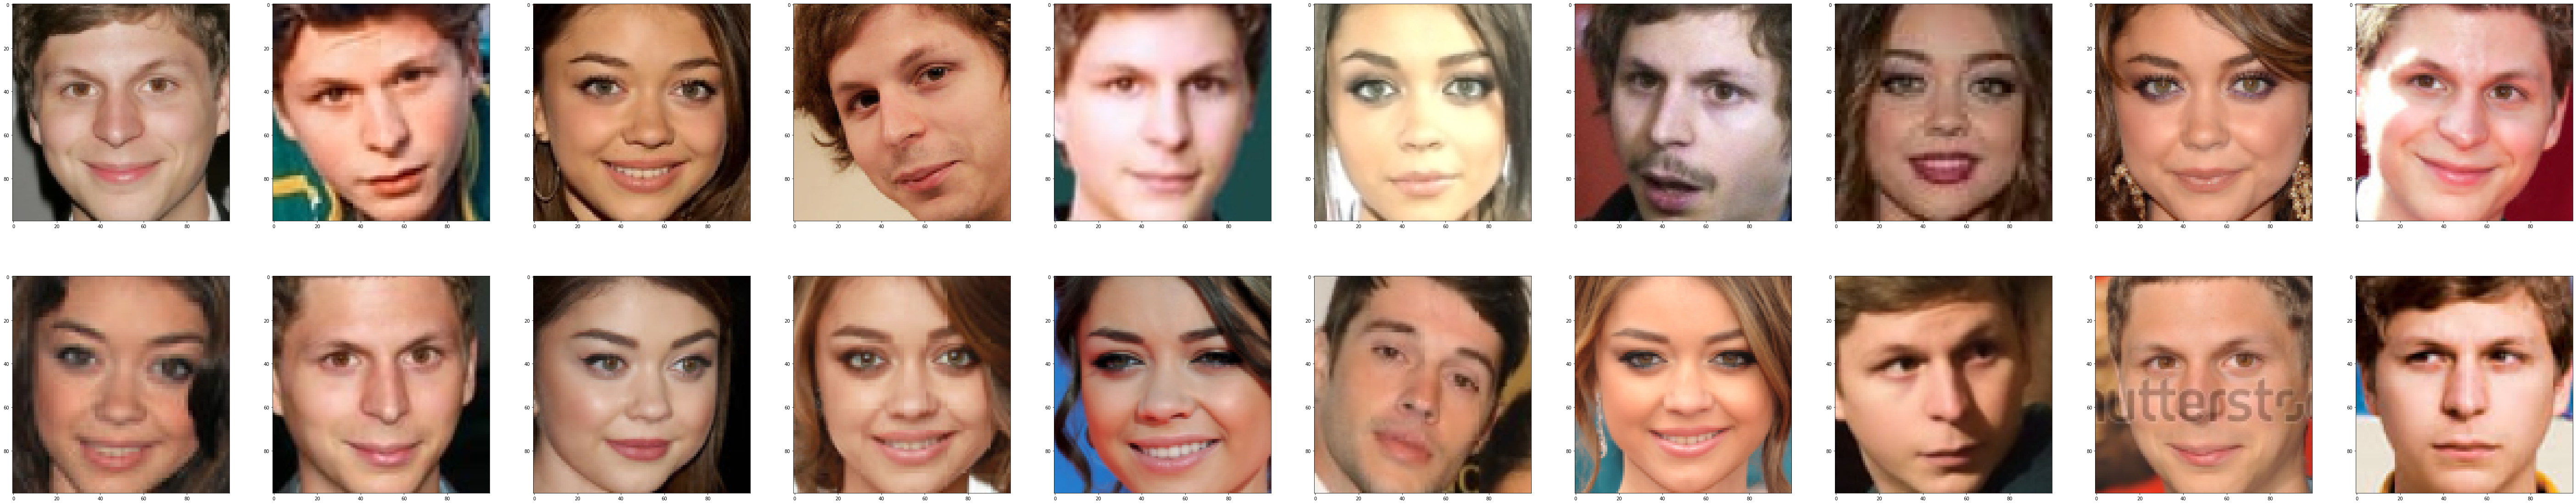

In [10]:
# plot faces of Michael and Sarah

plot_image_sequence(train_X[train_y == 0], n=20, imgs_per_row=10)

In [11]:
# test
print(train_X[1])

[[[22 14 11]
  [20 15 12]
  [21 16 13]
  ...
  [36 41 44]
  [36 41 44]
  [36 41 44]]

 [[22 16 13]
  [22 17 14]
  [21 17 15]
  ...
  [35 40 43]
  [35 40 43]
  [35 40 43]]

 [[25 20 17]
  [24 20 18]
  [22 18 17]
  ...
  [35 40 43]
  [35 40 43]
  [35 40 43]]

 ...

 [[51 33 23]
  [49 32 22]
  [46 31 21]
  ...
  [39 22 12]
  [41 24 14]
  [38 24 15]]

 [[51 33 23]
  [46 28 18]
  [44 29 18]
  ...
  [39 22 12]
  [41 24 14]
  [38 24 15]]

 [[53 35 25]
  [44 26 16]
  [43 26 16]
  ...
  [41 24 14]
  [41 25 15]
  [38 24 15]]]


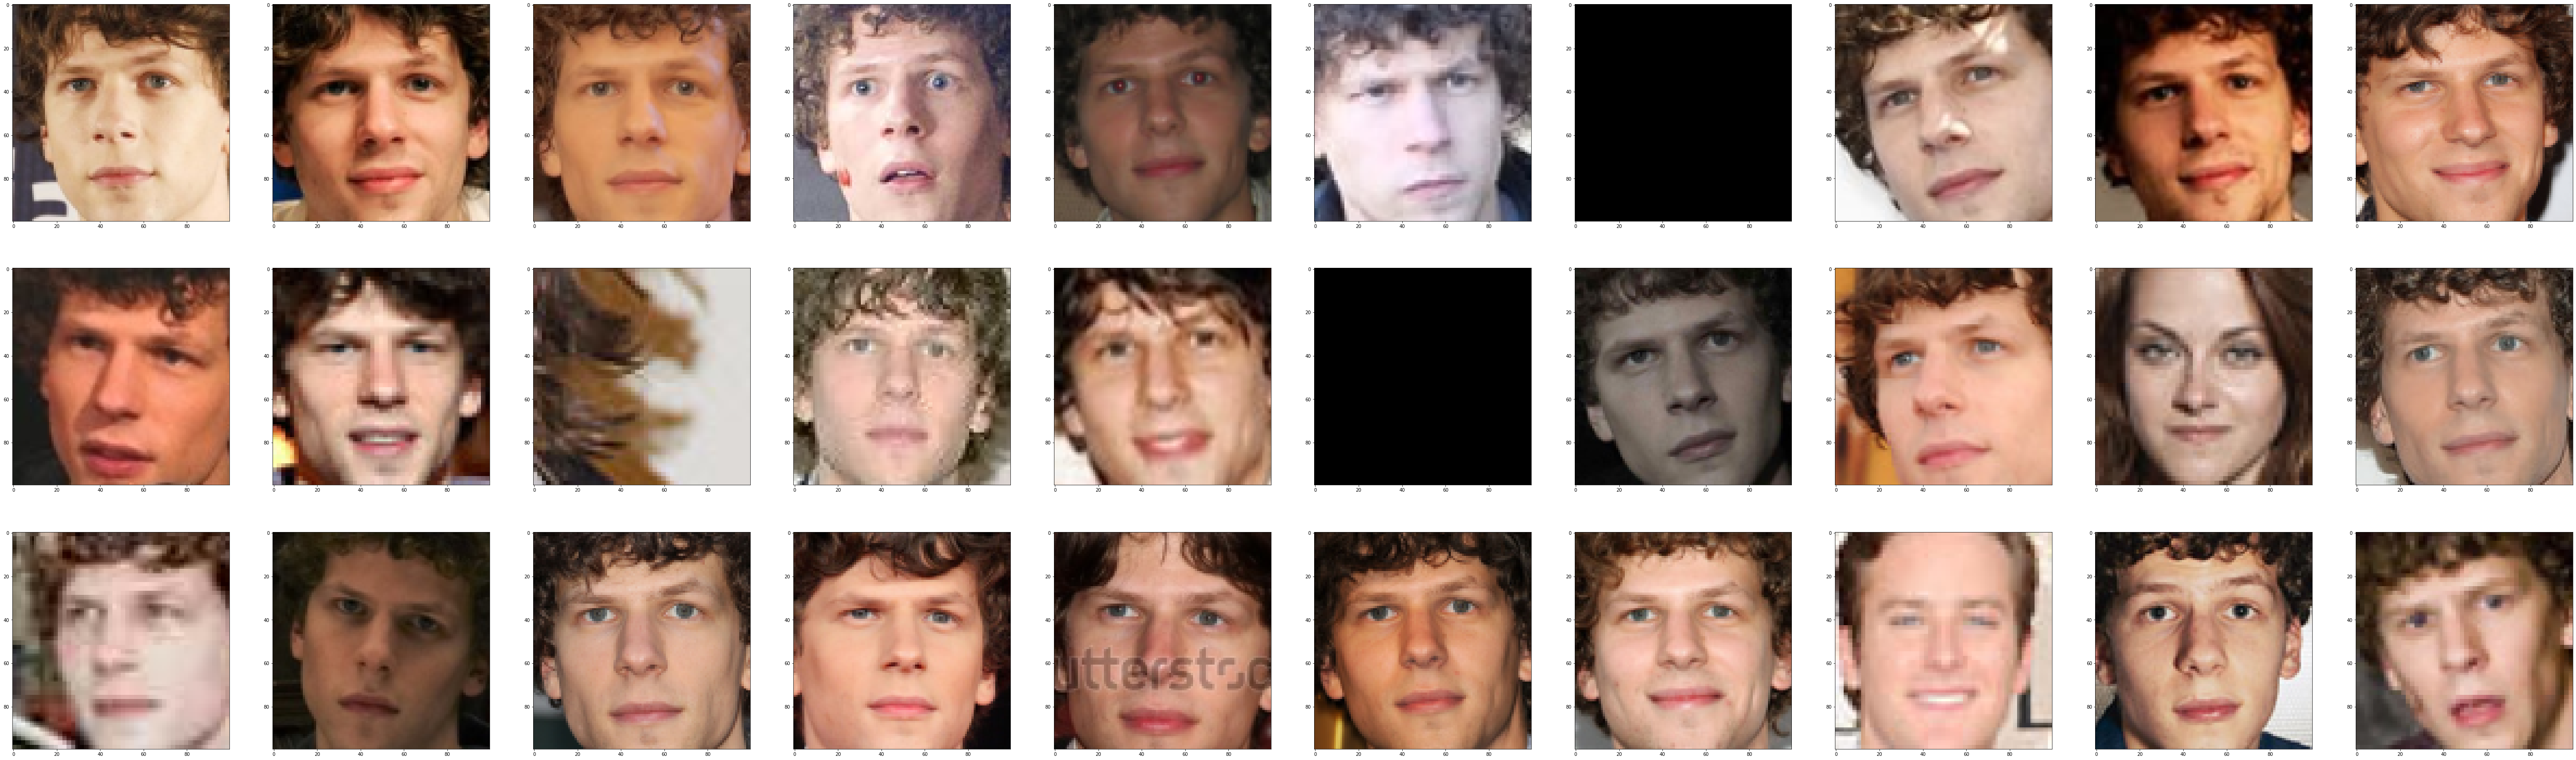

In [12]:
# plot faces of Jesse

plot_image_sequence(train_X[train_y == 1], n=30, imgs_per_row=10)

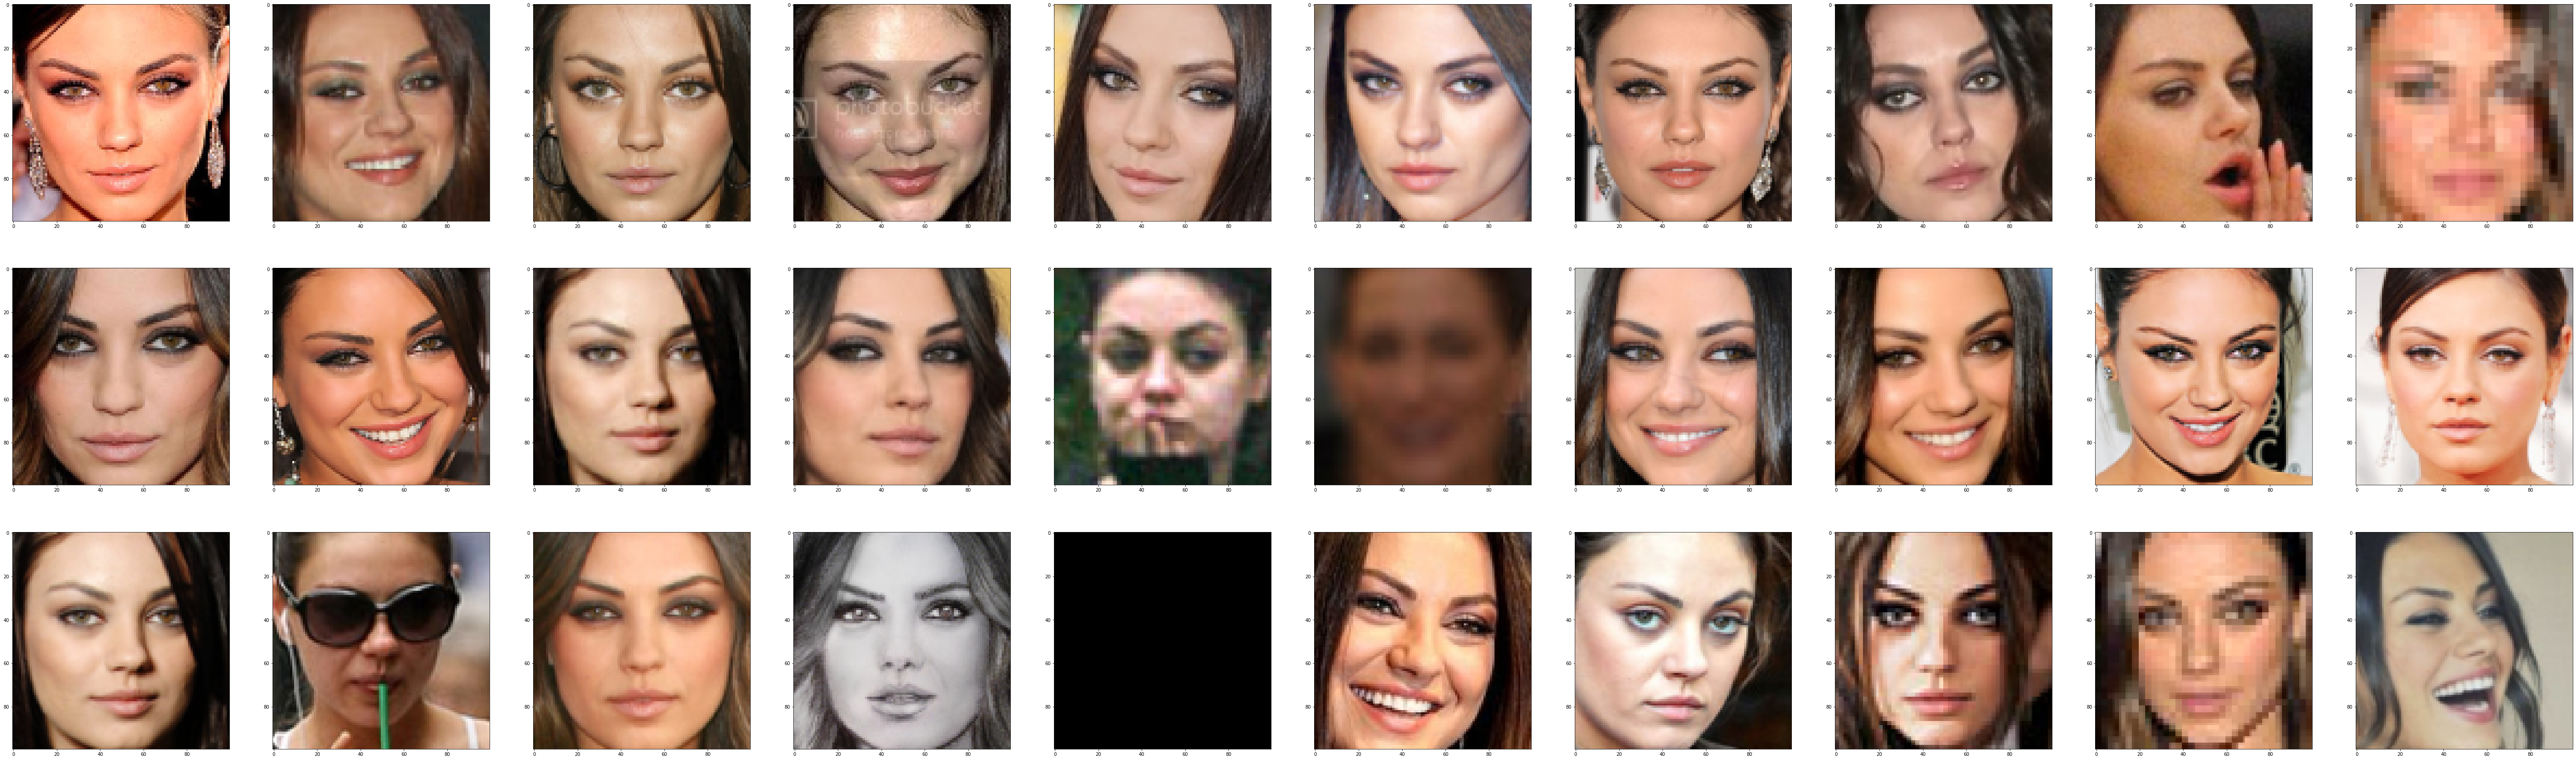

In [13]:
# plot faces of Mila

plot_image_sequence(train_X[train_y == 2], n=30, imgs_per_row=10)

## 0.4. Store Preprocessed data (optional)
<div class="alert alert-block alert-info">
<b>NOTE:</b> You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All". Feel free to use this to store intermediary results.
</div>

In [14]:
# save preprocessed data
# prep_path = '/kaggle/working/prepped_data/'
# if not os.path.exists(prep_path):
#     os.mkdir(prep_path)
    
# np.save(os.path.join(prep_path, 'train_X.npy'), train_X)
# np.save(os.path.join(prep_path, 'train_y.npy'), train_y)
# np.save(os.path.join(prep_path, 'test_X.npy'), test_X)

# load preprocessed data
# prep_path = '/kaggle/working/prepped_data/'
# if not os.path.exists(prep_path):
#     os.mkdir(prep_path)
# train_X = np.load(os.path.join(prep_path, 'train_X.npy'))
# train_y = np.load(os.path.join(prep_path, 'train_y.npy'))
# test_X = np.load(os.path.join(prep_path, 'test_X.npy'))

Now we are ready to rock!

# 1. Feature Representations
## 1.0. Example: Identify feature extractor
Our example feature extractor doesn't actually do anything... It just returns the input:
$$
\forall x : f(x) = x.
$$

It does make for a good placeholder and baseclass ;).

In [15]:
class IdentityFeatureExtractor:
    """A simple function that returns the input"""
    
    def transform(self, X):
        return X
    
    def __call__(self, X):
        return self.transform(X)

## 1.1. Baseline 1: HOG feature extractor/Scale Invariant Feature Transform

HOG and SIFT are both very similar feature descriptors. 
However, the HOG feature extractor is used more frequently in classification problems than SIFT. The latter is used more in identificating specific objects. By this reason, we decided to implement the HOG feature extractor.


The HOG feature extractor counts occurences of gradient orientations in a localized portion of an image. The purpose of this technique to receive a better objects detection by focusing on the structure/shape of an object. This technique is widely used in computer vision and image processing, and was introducedin a research paper of Dala and Triggs in 2005.
This technique returns mostly sligtly better results than other edge descriptors because it also uses the magnitude and angle gradient to compute features, from which it generates an histogram.


In [16]:
class HOGFeatureExtractor(IdentityFeatureExtractor):
    """
    https://www.thepythoncode.com/article/hog-feature-extraction-in-python

    """
    
    def __init__(self, X):
        self.X = X
        

    def save_extract(self):
        """         
         Saves images converted by HOG extractor
         
         Returns
         -------
         list_img : Array of arrays representing the Hog_images
        """
        n = self.X.shape
        list_img = []
        
        for i in range(n[0]):
            img = self.X[i]
            converted = np.float32(img)
            gray = cv2.cvtColor(converted, cv2.COLOR_BGR2GRAY)
            blur = cv2.GaussianBlur(gray,(5,5),cv2.BORDER_DEFAULT) # Gaussian Filtering
            fd, hog_image = hog(blur, orientations=10, pixels_per_cell=(5, 5), cells_per_block=(2, 2), block_norm="L2", visualize=True)

            list_img.append(hog_image)
        
        return list_img

    def plot_extract(self):
        n = self.X.shape
        imgs_per_row = 10
        n_rows = 1 + int(n[0]/(imgs_per_row+1))
        n_cols = min(imgs_per_row, n[0])
        list_img = []
        
        # creating hog features
        f,ax = plt.subplots(n_rows,n_cols, figsize=(10*n_cols,10*n_rows))

        for i in range(n[0]):
            img = self.X[i]
            converted = np.float32(img)
            gray = cv2.cvtColor(converted, cv2.COLOR_BGR2GRAY)
            blur = cv2.GaussianBlur(gray,(5,5),cv2.BORDER_DEFAULT) # Gaussian Filtering
            fd, hog_image = hog(blur, orientations=10, pixels_per_cell=(5, 5), cells_per_block=(2, 2), block_norm="L2", visualize=True)    

            list_img.append(hog_image)

            if n[0] == 1:
                ax.imshow(list_img[i])
            elif n_rows > 1:
                ax[int(i/imgs_per_row),int(i%imgs_per_row)].imshow(list_img[i])
            else:
                ax[int(i%n[0])].imshow(list_img[i])

        plt.show()  


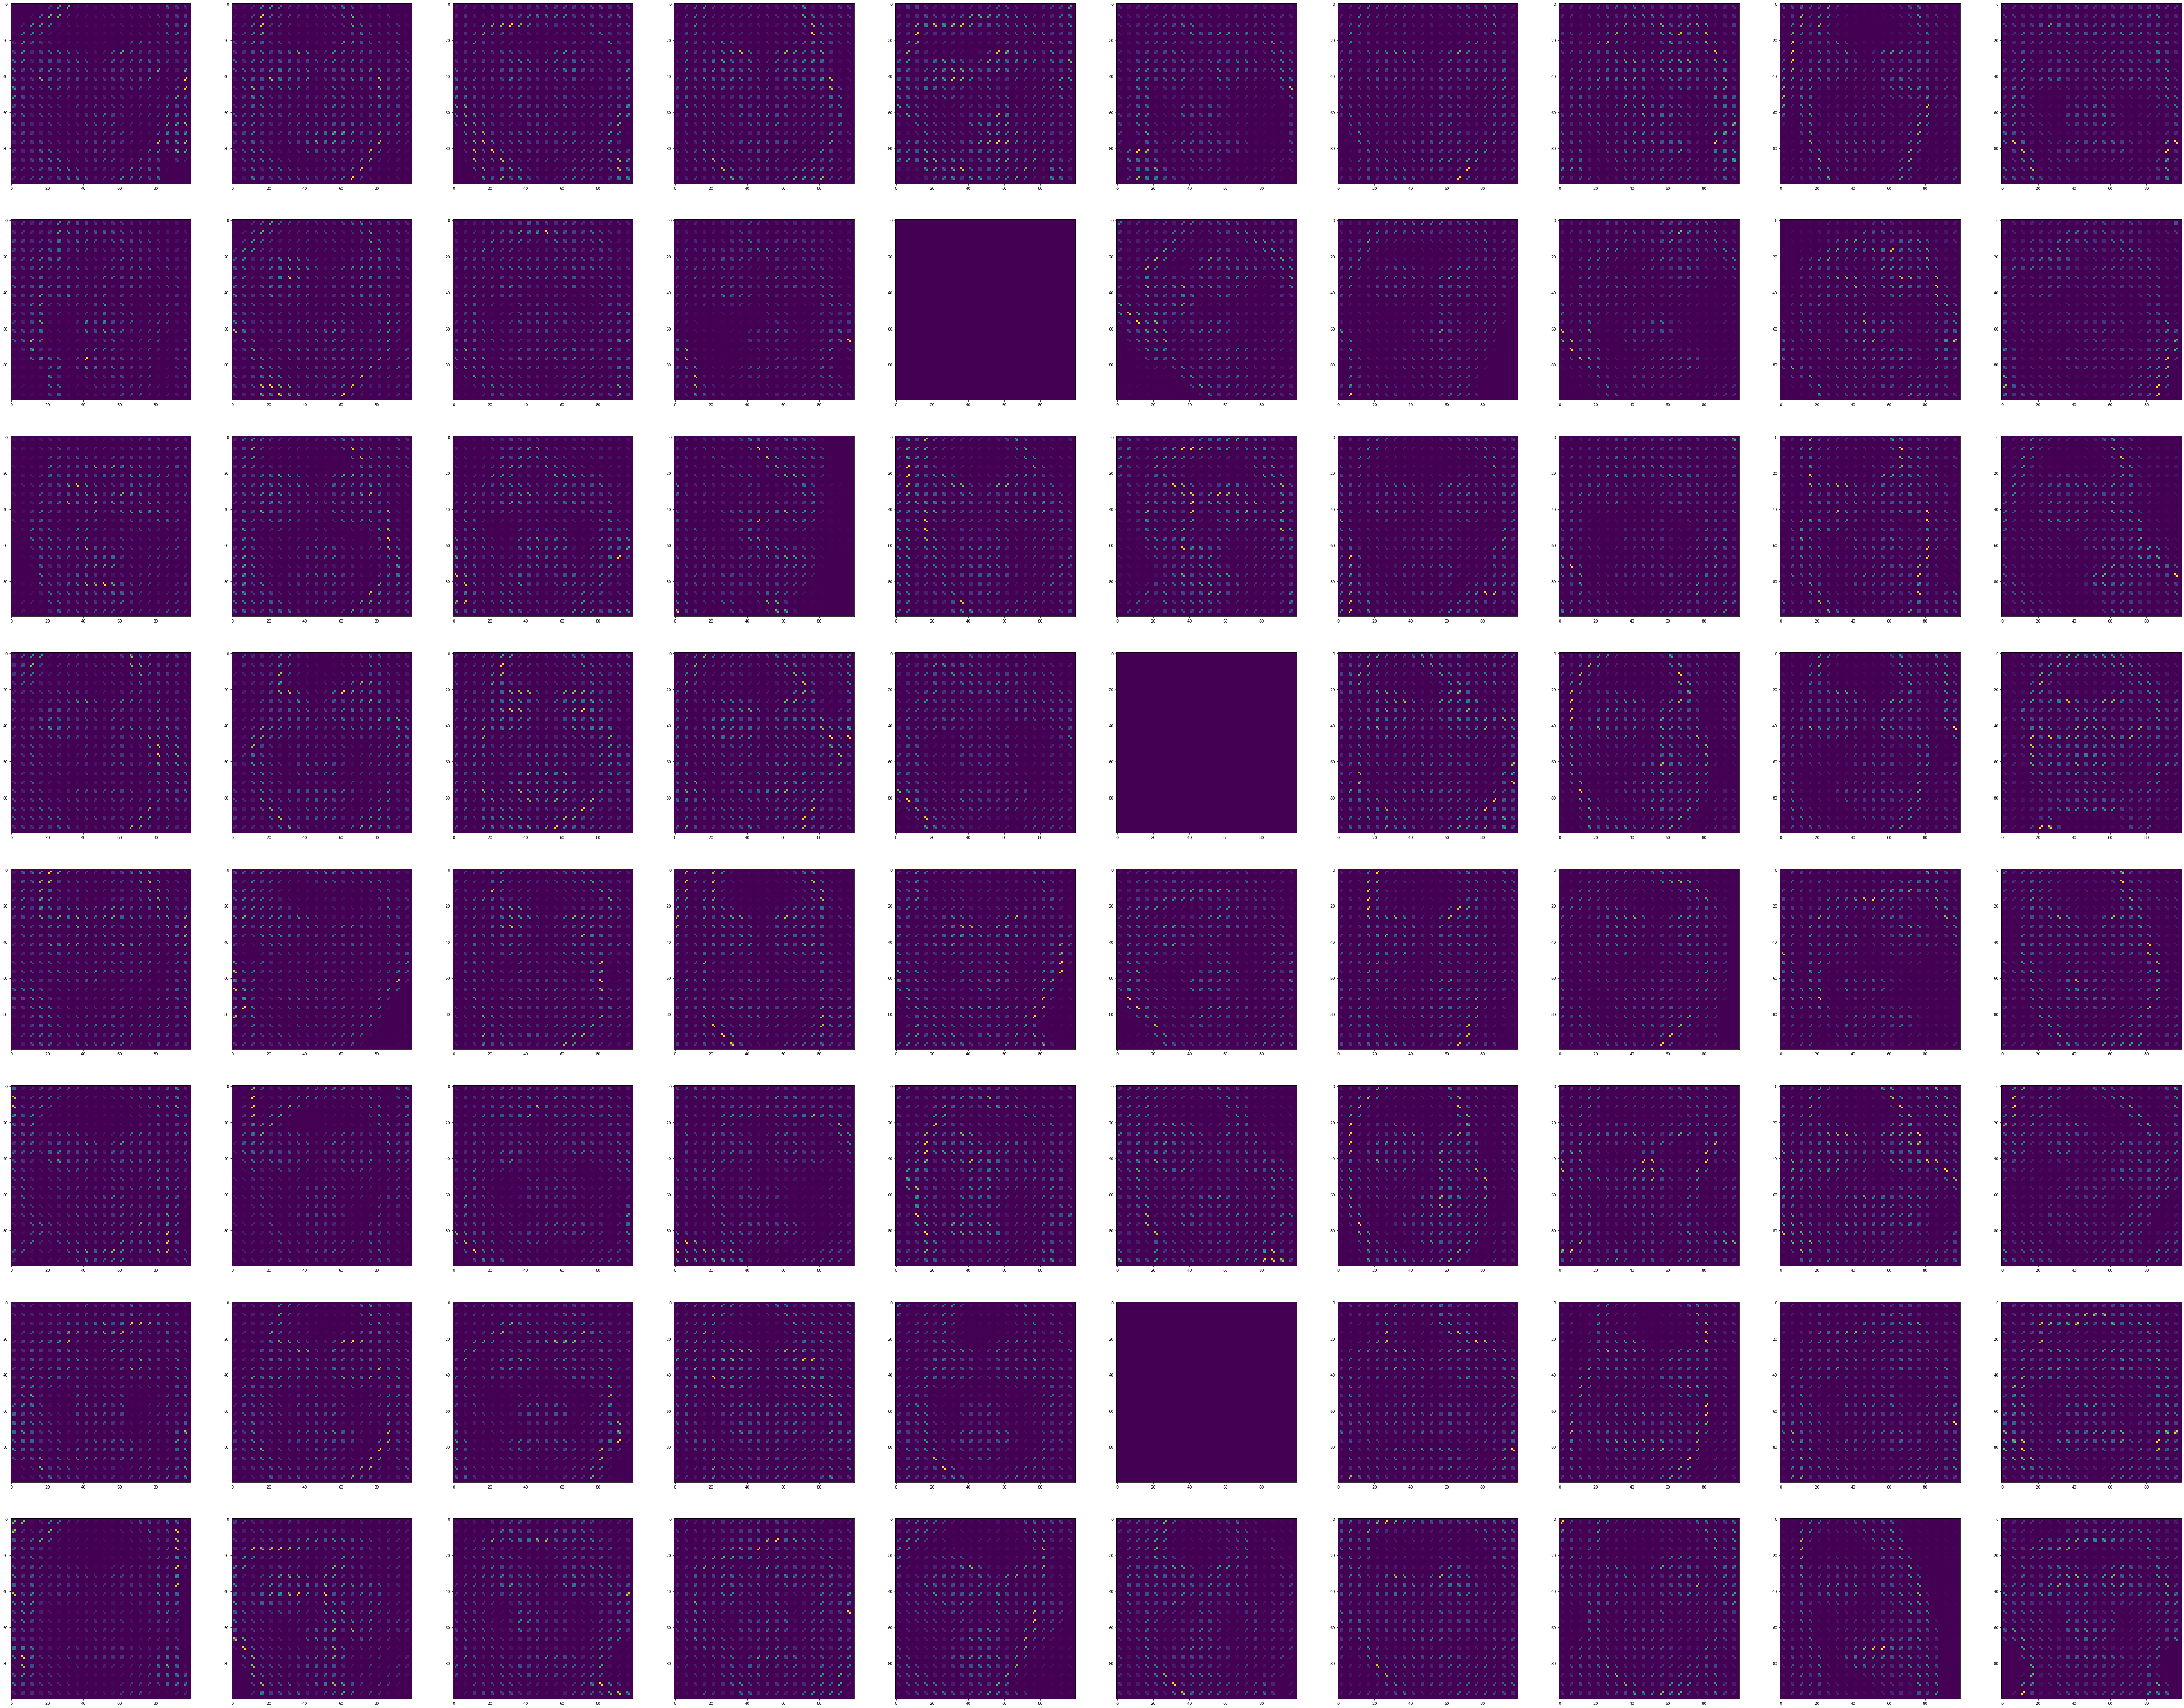

In [17]:
hog_model = HOGFeatureExtractor(train_X)

# Save the extracted data to /kaggle/working
hog_model.save_extract()

# plot the extracted data as hog
hog_model.plot_extract()

### 1.1.1. t-SNE Plots
t-Distributed Stochastic Neighbor Embedding (t-SNE) is not a mathematical technique as PCA, but a probabilistic one. It minimizes the divergence between two distributions: a distribution that measures pairwise similarities of the input objects and a distribution that measures pairwise similarities of the corresponding low-dimensional points in the embedding [REWRITE - DEF FROM THE INTERNET]

In [18]:
## Convert ImageData to a 2D matrix 
def set2Matrix(X):
    nb_train_images = len(X)
    size = FACE_SIZE[0]*FACE_SIZE[1]

    M = np.array(np.zeros([nb_train_images, size]))
    for n in range(nb_train_images):
        Im = X[n]
        A = np.asarray(Im).reshape(-1)
        M[n,:] = A
    return M

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


[t-SNE] Computing 79 nearest neighbors...
[t-SNE] Indexed 80 samples in 0.001s...
[t-SNE] Computed neighbors for 80 samples in 0.015s...
[t-SNE] Computed conditional probabilities for sample 80 / 80
[t-SNE] Mean sigma: 139.246285
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.203857
[t-SNE] KL divergence after 1000 iterations: 0.336853


[Text(0.5, 1.0, 't-SNE plot')]

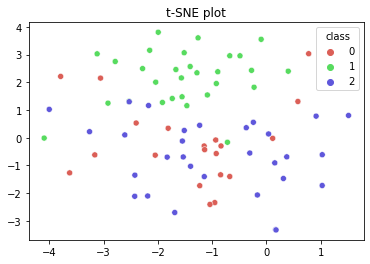

In [19]:
df = hog_model.save_extract()

M_hog = set2Matrix(df)


tsne = TSNE(n_components=2, verbose=1, perplexity=30.0, learning_rate=100, n_iter=1000)

tsne_results = tsne.fit_transform(M_hog)

TSNE1 = tsne_results[:,0].tolist()
TSNE2 = tsne_results[:,1].tolist()


sns.scatterplot(x=TSNE1, y=TSNE2, hue=train['class'], palette=sns.color_palette("hls", 3), data=M_hog, legend="full").set(title='t-SNE plot')


### 1.1.2. Discussion
#### a) How to make your descriptor behave well in different circumstances (e.g. image with different lighting)?
By simply **normalizing** the images with a 'L2' parameter, we **avoid brightness, contrast or other illumination effects**. This was done by adding `block_norm= ‘L2’` as a parameter of the HOG feature extractor. We could also have used L1 and L2-Hys as volunteering parameters. L2-Hys is sometimes used to reduce noise with the help of a L2-norm.


#### b) Visualize Feature Representation: [TODO]
t-SNE : This method classifies the images into clusters with similarities. Given N points -  $x_1,x_2,…,x_N$ in any dimension, t-SNE will compute the probability  pi,
j  the probability of similarity of  $x_i$  and  $x_j$ . The similarity is calculated based on the t-distribution. 
In practice given a cluster of N points t-SNE helps in finding clusters in which there exists similarity in the data points.

The parameters for t-SNE are number of components =2, perplexity=40 which governs the number of nearest neighbours, learning rate=200, if this is too high the data will look like a ball with equispaced nearest neighbours.     
number of iterations for optimization = 300. We also chose verbose = 1. The other various parameters were chosen to be default namely early_exaggeration, n_iter_without_progress, min_grad_norm,random_state=None, method='barnes_hut'.


#### c) How does this feature compare to your previous grabbing task in the individual assignment?
The HOG feature extractor is a gradient based method and is generally known as a more robust method than the one we used in the individual assignment. In the individual assignment, the object grabbing was based on a **threshold of a particular colour**. The HOG feature extractor in contrary, uses the **magnitude and slope** to compute features. It is computed by dividing an entire image into smaller cells an summing up their gradients over every pixel within each cell in an image.


#### d) Did you need specific pre-processing steps before computing these feature descriptors on your images (which ones and why)?
First of all, we convert the images to a **grayscale** as a basement for the following steps. Then, before processing, the images have been **resized**. In the paper of Dalal and Triggs, dimensions 128x64 were advised. However, the size depends on the application. In the notebook, the images were already resized to 100x100 pixels. We tried to resize the images to 80x80, bit it gave worser results on the t-sne, so we kept te original proposed size. This was all done in the HAARpreprocessing phase.
Further, we **normalized** the images with a 'L2' parameter, **to avoid brightness, contrast or other illumination effects**. Other possible paramaters we could have used are L1 and L2-Hys. Finally, in order to take a few neighboring pixels into account instead of single pixel values as its true value, we performed a **Gaussian filtering**.

#### e) Did the visualisation show good discriminative and robustness properties? [TODO]
Yes the t-SNE is able to show 3 major clusters of Jesse, Mila and the look alike. The HOG is able to show the major features of a face like nose, boundary, eyes etc. This is only possible for 
images with distinct values in pixels. For the black images which are outliers this is not possible.


#### f) Discussing missing values

In class 1 and 2, several black images appear. This means that the black images only contain 0 values, thus no information. Consequently, we can remove those images since they do not help our algorithm in classifying the faces correctly. 

Thereby, a few images which do not contain a face, are added to the training set.
In statistics, it is advised noy to throw away outliers unless we surely know that they are measurement errors. This is why we decided to keep these images in our dataset. Thereby, they can probably help us not to overfit certain parameters of a face. 

## 1.2. Baseline 2: PCA feature extractor
...

In [20]:
#Preprocess images and convert Images to 2D matrix
def PreprocessPCA(X):
    n = X.shape[0]
    size = FACE_SIZE[0]*FACE_SIZE[1]
    M = np.zeros([n,size])
    for i in range(n):
        img = X[i]
        converted = np.float32(img)
        gray = cv2.cvtColor(converted, cv2.COLOR_BGR2GRAY) #Convert to Grayscale image
        blur = cv2.GaussianBlur(gray,(5,5),cv2.BORDER_DEFAULT) # Gaussian Filtering
        A = np.asarray(blur).reshape(-1)
        M[i,:] = A
    #Mean substraction
    M = M - M.mean(axis=1).reshape(M.shape[0], -1)
    return M

In [21]:
#Visualisation of images form a 2D datamatrix
def plot_MatrixAsImages(title, images, n_col=3, n_row=5, cmap=plt.cm.gray):
    plt.figure(figsize=(2.0 * n_col, 2.26 * n_row))
    plt.suptitle(title, size=16)
    for i, comp in enumerate(images):
        plt.subplot(n_row, n_col, i + 1)
        vmax = max(comp.max(), -comp.min())
        plt.imshow(
            comp.reshape(FACE_SIZE),
            cmap=cmap,
            interpolation="nearest",
            vmin=-vmax,
            vmax=vmax,
        )
        plt.xticks(())
        plt.yticks(())
    plt.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.0)

In [22]:
# from sklearn.decomposition import PCA
class PCAFeatureExtractor(IdentityFeatureExtractor):
    """TODO: this feature extractor is under construction"""
    
    def __init__(self, n_components):
        self.n_components = n_components
        self.estimator = PCA(n_components=self.n_components, svd_solver="randomized", whiten=True)
        
    def fit(self,X):
        self.estimator.fit(X)
        components = self.estimator.components_
        return components
        
    def transform(self, X):
        Xc = self.estimator.transform(X)
        return Xc
        

    def inverse_transform(self, X):
        Xc = self.estimator.inverse_transform(X)
        return Xc

### 1.2.1. Eigenface Plots
...

In [23]:
## Convert images to 2D matrix with preprocessing
M_pca = PreprocessPCA(train_X)

Nb of components for 90.0 % of variance: 25


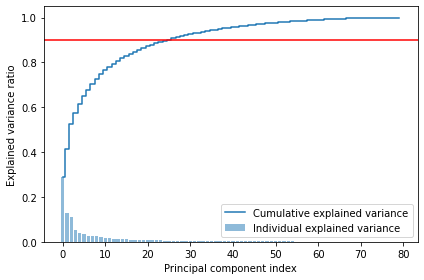

In [24]:
#Nb non-zero singular values: 80% -> 6 components
PCA_N = PCAFeatureExtractor(M_pca.shape[0])
comp = PCA_N.fit(M_pca)
exp_var_pca = PCA_N.estimator.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

perc = 0.9
N = [ n for n,i in enumerate(cum_sum_eigenvalues) if i>perc ][0]
print('Nb of components for',perc*100,'% of variance:',N)

plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.axhline(y=perc, color='r', linestyle='-')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

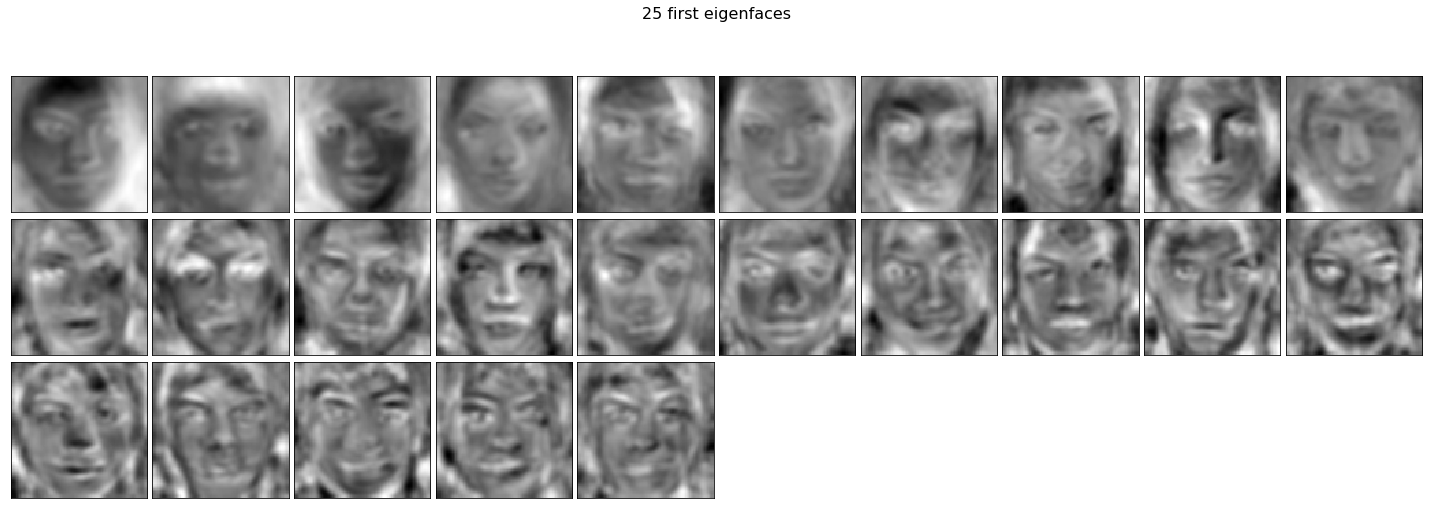

In [25]:
PCA_Ncomp = PCAFeatureExtractor(N)
Ncomp = PCA_Ncomp.fit(M_pca)
Title = str(N)+' first eigenfaces' 
plot_MatrixAsImages(Title , Ncomp,10,8)
plt.show()

### 1.2.2. Feature Space Plots
...

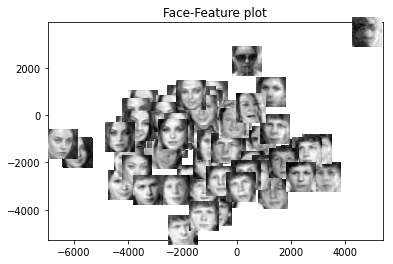

In [26]:
X_N = PCA_Ncomp.transform(M_pca)
Reconstruction = PCA_Ncomp.inverse_transform(X_N)
Y = np.matmul(M_pca, Ncomp[:2,:].T)


##Plot projected faces on the N-components on the feacture space
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
fig = plt.figure()
axes = fig.add_subplot(111)
plt.title("Face-Feature plot")
axes.scatter(Y[:,0],Y[:,1])
for i in range(M_pca.shape[0]):
    im = OffsetImage(Reconstruction[i,:].reshape(FACE_SIZE),zoom=0.3,cmap=plt.cm.gray)
    ab = AnnotationBbox(im, (Y[i,0],Y[i,1]), frameon=False)
    axes.add_artist(ab)

### 1.2.3. Discussion
...

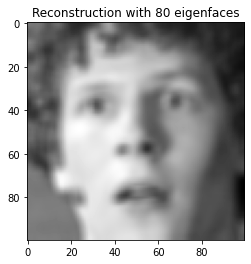

In [27]:
##Reconstruction

for i in range(1,81):
    PCA_recon = PCAFeatureExtractor(i)
    compR = PCA_recon.fit(M_pca)
    X_R = PCA_recon.transform(M_pca)
    Reconstruction = PCA_recon.inverse_transform(X_R)
    #Plot resinstruction of the 10th image
    clear_output(wait=True)
    plt.imshow(Reconstruction[10,:].reshape(100,100),cmap=plt.cm.gray)
    Title = "Reconstruction with "+str(i)+" eigenfaces"
    plt.title(Title)
    plt.show()
    time.sleep(0.5)

# 2. Evaluation Metrics
## 2.0. Example: Accuracy
As example metric we take the accuracy. Informally, accuracy is the proportion of correct predictions over the total amount of predictions. It is used a lot in classification but it certainly has its disadvantages...

In [28]:
from sklearn.metrics import accuracy_score

# 3. Classifiers
## 3.0. Example: The *'not so smart'* classifier
This random classifier is not very complicated. It makes predictions at random, based on the distribution obseved in the training set. **It thus assumes** that the class labels of the test set will be distributed similarly to the training set.

In [29]:
class RandomClassificationModel:
    """Random classifier, draws a random sample based on class distribution observed 
    during training."""
    
    def fit(self, X, y):
        """Adjusts the class ratio instance variable to the one observed in y. 

        Parameters
        ----------
        X : tensor
            Training set
        y : array
            Training set labels

        Returns
        -------
        self : RandomClassificationModel
        """
        
        self.classes, self.class_ratio = np.unique(y, return_counts=True)
        self.class_ratio = self.class_ratio / self.class_ratio.sum()
        return self
        
    def predict(self, X):
        """Samples labels for the input data. 

        Parameters
        ----------
        X : tensor
            dataset
            
        Returns
        -------
        y_star : array
            'Predicted' labels
        """

        np.random.seed(0)
        return np.random.choice(self.classes, size = X.shape[0], p=self.class_ratio)
    
    def __call__(self, X):
        return self.predict(X)
    

## 3.1. Baseline 1: My favorite classifier
Best classifiers with HOG as base:
- SVM
- Random Forest
- KNN

In [30]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

In [31]:
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier


class FavoriteClassificationModel():
    """TODO: this classifier is under construction."""
    def __init__(self,name):
        self.name=name
        if self.name == "SVM": #Support Vector Machine
            self.model = svm.SVC()
            
        elif self.name == "DT": #Decision Tree
            self.model = DecisionTreeClassifier()
            
        elif self.name == "LR": #Linear regression
            self.model = LogisticRegression(random_state=0, max_iter=1000)
            
        elif self.name == "LR_OR": #Linear regression One VS Rest
            LR = LogisticRegression()
            self.model = OneVsRestClassifier(LR)
         
        elif self.name == "Perceptron": #Perceptron
            self.model = Perceptron(tol=1e-3, random_state=0)
        
        elif self.name == "RC": #Ridge Classifier
            self.model =RidgeClassifier()
            
        elif self.name == "kNN": #k neighbors
            self.model = KNeighborsClassifier(leaf_size=1, p=2, n_neighbors=1)
            
        elif self.name == "RF": #Random Forest
            self.model = RandomForestClassifier(max_depth=2, random_state=0)
            
        else:
            print('No such a classifier')
        
    def fit(self, X, y):
         self.model.fit(X, y)
#         raise NotImplmentedError
        
    def predict(self, X):
        return self.model.predict(X)
#         raise NotImplmentedError

# 4. Experiments
<div class="alert alert-block alert-info"> <b>NOTE:</b> Do <i>NOT</i> use this section to keep track of every little change you make in your code! Instead, highlight the most important findings and the major (best) pipelines that you've discovered.  
</div>
<br>

## 4.0. Example: basic pipeline
The basic pipeline takes any input and samples a label based on the class label distribution of the training set. As expected the performance is very poor, predicting approximately 1/4 correctly on the training set. There is a lot of room for improvement but this is left to you ;). 

In [32]:
# HOG

# We are training on all the data.
feature_extractor_train = HOGFeatureExtractor(train_X)
feature_extractor_test = HOGFeatureExtractor(test_X)

hog_train = feature_extractor_train.save_extract()
hog_test = feature_extractor_test.save_extract()


# TRANSFORM TRAIN SET
M_hog_train = set2Matrix(hog_train)

# TRANSFORM TEST SET
M_hog_test = set2Matrix(hog_test)


In [33]:
# PCA
# convert original data to the features

# TRANSFORM TRAIN SET
Train = PreprocessPCA(train_X)
PCA_FE = PCAFeatureExtractor(N)
comp = PCA_FE.fit(Train)
M_pca_train = PCA_FE.transform(Train)
# TRANSFORM TEST SET
Test = PreprocessPCA(test_X)
M_pca_test = PCA_FE.transform(Test)

In [34]:
# DT Hog
DT_model = FavoriteClassificationModel("DT")
DT_model.fit(M_hog_train, train_y)
DT_predict = DT_model.predict(M_hog_test)

In [35]:
# LR Hog
LR_model = FavoriteClassificationModel("LR")
LR_model.fit(M_hog_train, train_y)
LR_predict = LR_model.predict(M_hog_test)

In [36]:
# SVM Hog
SVM_model = FavoriteClassificationModel("SVM")
SVM_model.fit(M_hog_train, train_y)
SVM_predict = SVM_model.predict(M_hog_test)

In [37]:
# Perceptron Hog
PE_model = FavoriteClassificationModel("Perceptron")
PE_model.fit(M_hog_train, train_y)
PE_predict = PE_model.predict(M_hog_test)

In [38]:
# RC Hog
RC_model = FavoriteClassificationModel("RC")
RC_model.fit(M_hog_train, train_y)
RC_predict = RC_model.predict(M_hog_test)

In [39]:
# kNN Hog
neigh_model = FavoriteClassificationModel("kNN")
neigh_model.fit(M_hog_train, train_y)
neigh_predict = neigh_model.predict(M_hog_test)

In [40]:
# RF Hog
RF_model = FavoriteClassificationModel("RF")
RF_model.fit(M_hog_train, train_y)
RF_predict = RF_model.predict(M_hog_test)

In [41]:
# LR ONEVSREST PCA
LR_model_PCA = FavoriteClassificationModel("LR_OR")
LR_model_PCA.fit(M_pca_train, train_y)
LR_predict_pca = LR_model_PCA.predict(M_pca_test)

Check how many from each class

In [42]:
Ty = DT_predict.copy()
print(Ty[Ty==0].shape)
print(Ty[Ty==1].shape)
print(Ty[Ty==2].shape)

(483,)
(606,)
(727,)


In [43]:
Ty = SVM_predict.copy()
print(Ty[Ty==0].shape)
print(Ty[Ty==1].shape)
print(Ty[Ty==2].shape)

(182,)
(670,)
(964,)


In [44]:
Ty = neigh_predict.copy()
print(Ty[Ty==0].shape)
print(Ty[Ty==1].shape)
print(Ty[Ty==2].shape)

(788,)
(686,)
(342,)


In [45]:
Ty = LR_predict.copy()
print(Ty[Ty==0].shape)
print(Ty[Ty==1].shape)
print(Ty[Ty==2].shape)

(678,)
(598,)
(540,)


In [46]:
Ty = PE_predict.copy()
print(Ty[Ty==0].shape)
print(Ty[Ty==1].shape)
print(Ty[Ty==2].shape)

(708,)
(754,)
(354,)


In [47]:
Ty = RC_predict.copy()
print(Ty[Ty==0].shape)
print(Ty[Ty==1].shape)
print(Ty[Ty==2].shape)

(682,)
(630,)
(504,)


In [48]:
Ty = RF_predict.copy()
print(Ty[Ty==0].shape)
print(Ty[Ty==1].shape)
print(Ty[Ty==2].shape)

(57,)
(755,)
(1004,)


In [49]:
Ty = LR_predict_pca.copy()
print(Ty[Ty==0].shape)
print(Ty[Ty==1].shape)
print(Ty[Ty==2].shape)
##Score 0.61894

(509,)
(658,)
(649,)


In [50]:
# evaluate performance of the model on the training set
#train_y_star = model(train_X)

#train_y_star = model(X_train)
#train_y_star = model(M_hog_train)

#model(X_train)

#"The performance on the training set is {:.2f}. This however, does not tell us much about the actual performance (generalisability).".format(
#    accuracy_score(train_y, train_y_star))

In [51]:
# predict the labels for the test set 
#test_y_star = model(X_test)
test_y_star = LR_predict

print(test_y_star)

[1 0 0 ... 1 0 0]


In [52]:
test_y_star = SVM_predict

print(test_y_star)

[1 2 0 ... 1 2 2]


In [53]:
test_y_star = neigh_predict

print(test_y_star)

[1 2 0 ... 1 0 0]


In [54]:
test_y_star = LR_predict

print(test_y_star)

[1 0 0 ... 1 0 0]


In [55]:
test_y_star = PE_predict

print(test_y_star)

[1 0 0 ... 1 0 0]


In [56]:
test_y_star = RC_predict

print(test_y_star)

[1 0 0 ... 1 0 0]


In [57]:
test_y_star = LR_predict_pca

print(test_y_star)

[1 2 0 ... 1 0 0]


In [73]:
# IMPROVEMENTS: Transfer learning

# libs needed
import tensorflow as tf
from tensorflow.keras.models import  Sequential, Model, load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, Dropout
import numpy as np
import os
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [111]:
from keras.applications import vgg16

img_rows, img_cols = 100, 100

vgg = vgg16.VGG16(weights = 'imagenet', include_top = False, input_shape = (img_rows, img_cols, 3), pooling = 'avg')

#freeze the last 4 layers
for layer in vgg.layers:
    layer.trainable = False
    
#print layers
for (i, layer) in enumerate(vgg.layers):
    print(str(i) + "" + layer.__class__.__name__, layer.trainable)

0InputLayer False
1Conv2D False
2Conv2D False
3MaxPooling2D False
4Conv2D False
5Conv2D False
6MaxPooling2D False
7Conv2D False
8Conv2D False
9Conv2D False
10MaxPooling2D False
11Conv2D False
12Conv2D False
13Conv2D False
14MaxPooling2D False
15Conv2D False
16Conv2D False
17Conv2D False
18MaxPooling2D False
19GlobalAveragePooling2D False


In [115]:
#from keras.preprocessing import image as kimage

#dummy_y = y_train

#pre_processing = kimage.ImageDataGenerator(preprocessing_function = keras.applications.vgg16.preprocess_input) 
#generator_train = pre_processing.flow(X_train, dummy_y)
#generator_test = pre_processing.flow(X_test, dummy_val)

In [93]:
def lw(bottom_model, num_classes):
    """
    creates top/head of model that will be placed ontop of the bottom layers
    """
    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    #top_model = Dense(1024, activation='relu')(top_model)
    #top_model = Dense(1024, activation='relu')(top_model)
    top_model = Dense(128, activation='relu')(top_model)
    top_model = Dense(128, activation='relu')(top_model)
    top_model = Dense(64, activation='relu')(top_model)
    #top_model = Dense(num_classes, activation='softmax')(top_model)
    top_model = Dense(num_classes, activation='sigmoid')(top_model)
    return top_model

In [76]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
#from keras.layers.normalization import BatchNormalization
from keras.models import Model

In [110]:
#num_classes = 3
num_classes = 1

FC_Head = lw(vgg, num_classes)

model = Model(inputs = vgg.input, outputs = FC_Head)
print(model.summary())

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0   

In [78]:
from keras.preprocessing.image import ImageDataGenerator
# split test/validation set

X_train, X_val, y_train, y_val = train_test_split(train_X, train_y, test_size=0.2, random_state=1)

#train_data_dir = '/kaggle/input/computer-vision-assignment/kul-h02a5a-computer-vision-ga1-2022/train'
#validation_data_dir = '/kaggle/input/computer-vision-assignment/kul-h02a5a-computer-vision-ga1-2022/test'

#print(train_data_dir)

#print(len(X_train))

In [79]:
# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    width_shift_range=0.3,
    height_shift_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest')

print(train_datagen)

validation_datagen = ImageDataGenerator(rescale=1./255)

In [80]:
batch_size = 32

#print(df[1])

#['class'] ['img']
#1           [[[...]]] -> filenames
#3

train_generator = train_datagen.flow(
    X_train,
    y_train,
    batch_size=batch_size,
)


In [81]:
validation_generator = validation_datagen.flow(
    X_val,
    y_val,
    batch_size=batch_size
)

#problem: cannot find images, maybe because npy classes and we work different (with .cvs?

In [82]:
from tensorflow.keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [83]:
checkpoint = ModelCheckpoint("face recognisation.h5",
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystop = EarlyStopping(monitor='val_loss',
                         min_delta=0,
                         patience=3,
                         verbose=1,
                         restore_best_weights = True)

# put call back into callback list
callbacks = [earlystop, checkpoint]

In [96]:
# use small learning rate

model.compile(loss = 'categorical_crossentropy',
             optimizer= RMSprop(lr=0.001),
             metrics=['accuracy'])

nb_train_samples = 80

In [97]:
from sklearn.datasets import make_blobs
from sklearn.preprocessing import MinMaxScaler
# generate 2d classification dataset
blah_X, blah_y = make_blobs(n_samples=100, centers=2, n_features=2, random_state=1)

print(blah_y)

[0 1 0 0 1 1 1 1 0 0 1 0 1 0 1 1 1 0 0 1 1 1 1 0 0 1 1 0 0 1 0 0 1 0 1 1 0
 1 1 1 1 1 0 1 0 1 0 0 0 0 0 1 1 1 0 1 0 1 0 0 0 1 1 1 1 1 0 1 0 0 1 1 1 0
 0 0 1 1 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 1 1 1 0 1 0]


In [98]:
# Enter the number of training and validation samples here
nb_train_samples = 64
nb_validation_samples = 16

# We only train 5 EPOCHS 
epochs = 5
batch_size = 16

history = model.fit_generator(
    train_generator,
    steps_per_epoch = nb_train_samples // batch_size,
    epochs = epochs,
    #callbacks = callbacks,
    validation_data = validation_generator,
    validation_steps = nb_validation_samples // batch_size
    #validation_steps = 4
)

Epoch 1/5
4/4 [==============================] - 6s 1s/step - loss: 0.0000e+00 - accuracy: 0.3750 - val_loss: 0.0000e+00 - val_accuracy: 0.4375


In [122]:
from sklearn.preprocessing import OneHotEncoder

#enc = OneHotEncoder(handle_unknown='ignore')
#train_y_enc = enc.fit(train_y)

#model.fit(train_X, train_y, epochs=2)
model.predict(train_X)
#print(model.summary())

encoded_arr = []

# encoding 2 to [0 0 1]
for i in range(len(train_y)):
    if (train_y[i]==2):
        m = np.array([0, 0, 1])
    elif(train_y[i]==1):
        m = np.array([0, 1, 0])
    elif(train_y[i]==0):
        m = np.array([1, 0, 0])
    #print(encoded_arr) 
    encoded_arr.append(m)
    
encoded_array = np.array(encoded_arr)
fl_encoded_arr = encoded_array.flatten(order='A')
    
    
#print(train_X)
print(encoded_array)

[[0 0 1]
 [0 0 1]
 [1 0 0]
 [0 0 1]
 [1 0 0]
 [0 1 0]
 [0 0 1]
 [0 1 0]
 [0 0 1]
 [0 1 0]
 [0 1 0]
 [1 0 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [1 0 0]
 [1 0 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [1 0 0]
 [0 1 0]
 [0 1 0]
 [0 0 1]
 [1 0 0]
 [0 0 1]
 [0 1 0]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [1 0 0]
 [0 0 1]
 [0 1 0]
 [0 1 0]
 [1 0 0]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [1 0 0]
 [1 0 0]
 [0 0 1]
 [1 0 0]
 [0 1 0]
 [0 0 1]
 [1 0 0]
 [0 1 0]
 [0 1 0]
 [0 0 1]
 [0 0 1]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [1 0 0]
 [0 0 1]
 [0 0 1]
 [1 0 0]
 [1 0 0]
 [0 1 0]
 [0 0 1]
 [0 1 0]
 [1 0 0]
 [0 0 1]
 [0 0 1]
 [0 1 0]
 [0 0 1]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [1 0 0]
 [0 1 0]
 [0 1 0]
 [0 0 1]
 [0 0 1]
 [1 0 0]
 [0 0 1]
 [0 0 1]
 [1 0 0]]


In [ ]:
encoded_array = np.array(encoded_arr)

#print(encoded_array)
#print(train_X)
print(model.summary())

model.fit(train_X, encoded_array)

train_X # 3 
print(train_y)  # 1

In [ ]:
from keras.models import load_model

classifier = load_model('/content/face recognisation.h5')

# 5. Publishing best results

In [ ]:
submission = test.copy().drop('img', axis = 1)
submission['class'] = test_y_star

submission

In [ ]:
submission.to_csv('submission.csv')


# 6. Discussion
...

In summary we contributed the following: 
* 
